# <font  color = "#0093AF">Exchange in 1D spectra</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_exchange1D.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

One of the most basic examples of dynamics manifesting in NMR spectra is the broadening driven by an exchange process that modulates the chemical shift of the system. To simulate this in SLEEPY, we must build two spin systems (`ex0`,`ex1`), with a different chemical shift in each system. Then, we couple the systems with an exchange matrix.

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
The first step is to build the system, which will have a single nucleus. The first copy of the system (`ex0`) has a chemical shift of -5 ppm, and a second copy (`ex1`) has a shift of +5 ppm.

In [3]:
ex0=sl.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
_=ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process (symmetric exchange)
First, we export this sytem into Liouville space (`L=sl.Liouvillian(ex0,ex1)`), allowing us to introduce an exchange process. Then we'll define a correlation time and the size of the two populations. To start, we assume the populations, $p_1$ and $p_2$ are equal.

In [4]:
L=sl.Liouvillian((ex0,ex1))           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1e-3     #Correlation time (10 s)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

kex=1/(2*tc)*(np.array([[-1,1],[1,-1]])+(p1-p2)*np.array([[1,1],[-1,-1]]))
#The above matrix can also be obtained from kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
L.kex=kex

## Run as a 1D Experiment
We'll start the magnetization on $S_x$ and observe $S^+$ (detecting $S^+$ gives us the real and imaginary components of the signal). To acquire the signal, we need a propagator or sequence from the Liouvillian. Here, we'll use a sequence (`seq=L.Sequence(...))`. We will then use the `rho.DetProp(...)` function to propagate that sequence `n` times.

In [5]:
rho=sl.Rho(rho0='13Cx',detect='13Cp')
#For a 10 ppm shift difference, Dt should be short enough to capture both peaks in the spectrum
#For 600 MHz 1H frequency, 10 ppm is approximately 10*150 Hz. 
#The 2 makes this twice as broad as the peak difference
Dt=1/(2*10*150)
# Empty sequence
seq=L.Sequence(Dt=Dt)  #For solution NMR, Dt must be specified

# Repeat the sequency 1024 times
_=rho.DetProp(seq,n=1024)

State-space reduction: 8->2


Note that `rho.DetProp` has reduced the Liouvillian from an 8x8 matrix to a 2x2 matrix. The 2x2 matrix is one representation of the Bloch-McConnell equations.$^1$

$$
\begin{equation}
\hat{\hat{L}}_{red.}=
\begin{pmatrix}
-k_{12}+i\Omega_1 & k_{21} \\
k_{12} & -k_{21}+i\Omega_2
\end{pmatrix}
\end{equation}
$$

This sub-matrix of $\hat{\hat{L}}$ corresponds to the $\hat{S}^+$ terms that are being detected. The simulation is also initiated with $\hat{S}^-$, since we start with $\hat{S}_x$ ($\hat{S}_x=\frac12(\hat{S}^++i\hat{S}^-)$). However, the $\hat{S}^-$ terms don't exchange with the $\hat{S}^+$ terms, and are also not detected, so we don't need to calculate them.

This is shown graphically below. To reduce the 8x8 Liouvillian to obtain only the 2x2 block required for simulation, we need to provide `rho` to the `L.plot(...)` function.

[1] H.M. McConnell. [*J. Chem. Phys.*](https://doi.org/10.1063/1.1744152), **1958**, 28, 430-431. 

State-space reduction: 8->2
State-space reduction: 8->2


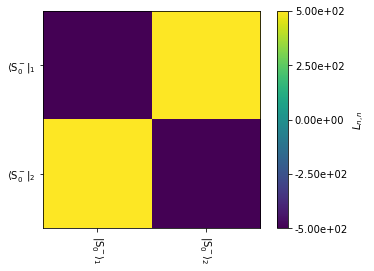

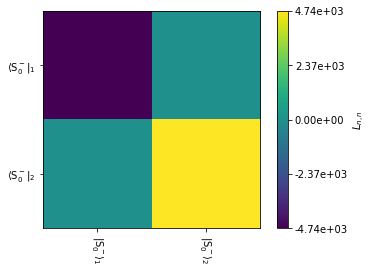

In [6]:
L.plot(rho=rho,mode='re')
_=L.plot(rho=rho,mode='im')

## Plot the results

We obtain the resulting spectrum under exchange conditions from `rho` by using the `rho.plot()` command. Setting `FT=True` gives the Fourier-transformed spectrum.

On this timescale, we still obtain two peaks, which are strongly broadened by the exchange process. We can sweep the correlation time to observe the coalescence of the peaks.

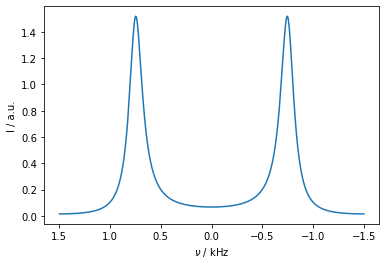

In [7]:
_=rho.plot(FT=True)

## Sweep through a range of correlation times to observe coalescence

In this example, we vary the timescale of exchange, from fast exchange where we obtain a relatively sharp peak, through coalescence, and to slow exchange where we again obtain two narrow peaks. We set `L.kex` using the built-in tool `twoSite_kex(tc=...)`.

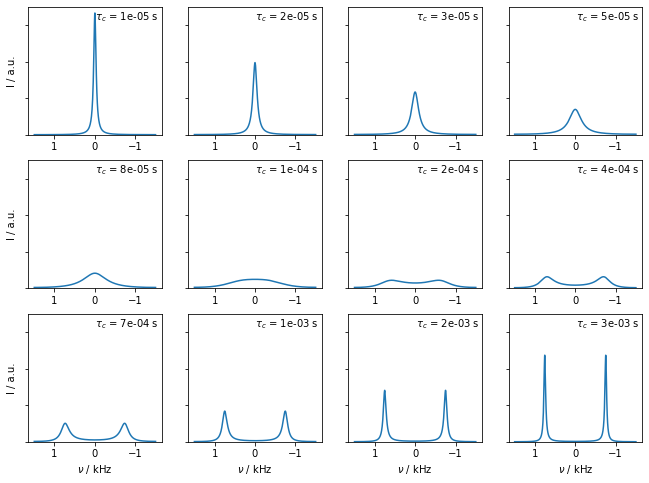

In [8]:
sl.Defaults['verbose']=False  #If SLEEPY outputs get annoying, you can turn them off
tc0=np.logspace(-5,-2.5,12) #Correlation times to sweep through
fig,ax=plt.subplots(3,4,figsize=[11,8]) # Plots to show data
ax=ax.flatten() #ax is a 3x4 matrix of axes to plot into. This makes it 1D for the for loop
sm=0
for tc,a in zip(tc0,ax):
    L.kex=sl.Tools.twoSite_kex(tc=tc)
    rho.clear()
    rho.DetProp(seq,n=1024)
    rho.plot(FT=True,ax=a)
    sm=max(sm,a.get_ylim()[1]) #Find maximum axis limit

#make the plots nicers (this is just python, no SLEEPY functions)
for tc,a in zip(tc0,ax):
    a.set_ylim([0,sm])
    if not(a.is_last_row()):
        a.set_xlabel('')
    if not(a.is_first_col()):
        a.set_ylabel('')
    a.set_yticklabels('')
    a.text(-.01,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')

In symmetic exchange, we can obtain the peak positions and linewidths by diagonalizing the following equation:

$$
\begin{equation}
\hat{\hat{L}}=
\begin{pmatrix}
-k+i\Delta\Omega/2 & k \\
k & -k-i\Delta\Omega/2
\end{pmatrix}
\end{equation}
$$

In this case, the eigenvalues are obtained from the roots of the determinant of the Liouvillian

$$
\begin{eqnarray}
0&=&\det\left[
\begin{pmatrix}
-k+i\Delta\Omega/2-\lambda & k \\
k & -k-i\Delta\Omega/2-\lambda
\end{pmatrix}\right] \\
0&=&\lambda^2+k^2+(\Delta\Omega/2)^2+\lambda(k+i\Delta\Omega/2)+\lambda(k-i\Delta\Omega/2)-k^2 \\
0&=&\lambda^2+2k\lambda+\frac{\Delta\Omega}{2}
\end{eqnarray}
$$

Here, we may apply the quadratic equation

$$
\begin{equation}
\lambda=-k\pm\sqrt{k^2-\frac14\Delta\Omega^2}
\end{equation}
$$

Then, when the term in the square-root is negative, we obtain complex eigenvalues, corresponding to two separate oscillation frequencies, and $T_2$=1/k. When the square-root is positive, then no observable frequency difference arises, but two different decay rates are present (as $k$ becomes larger, only the smaller rate contributes significantly to the spectrum).

On the other hand, if $k_{12}\ne k_{21}$, then no well-defined coalescence condition exists. We simulate this case below, as a function of exchange rate.

## Repeat with asymmetric exchange

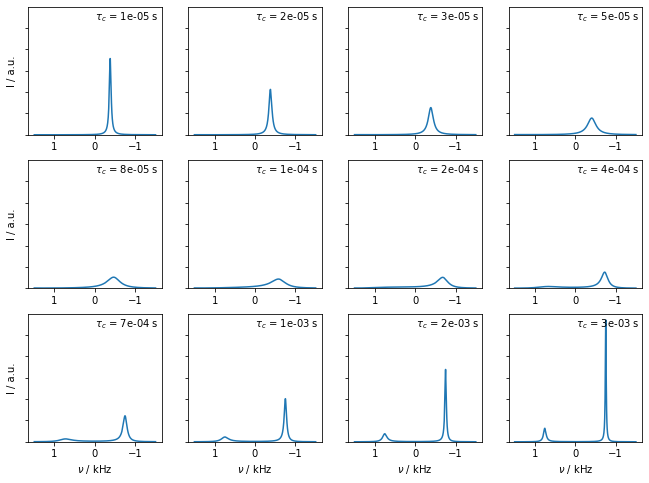

In [9]:
p1=0.75
p2=1-p1

sl.Defaults['verbose']=False  #If SLEEPY outputs get annoying, you can turn them off
tc0=np.logspace(-5,-2.5,12) #Correlation times to sweep through
fig,ax=plt.subplots(3,4,figsize=[11,8]) # Plots to show data
ax=ax.flatten() #ax is a 3x4 matrix of axes to plot into. This makes it 1D for the for loop
sm=0
for tc,a in zip(tc0,ax):
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    rho.clear()
    rho.DetProp(seq,n=1024)
    rho.plot(FT=True,ax=a)
    sm=max(sm,a.get_ylim()[1]) #Find maximum axis limit

#make the plots nicers (this is just python, no sleepy functions)
for tc,a in zip(tc0,ax):
    a.set_ylim([0,sm])
    if not(a.is_last_row()):
        a.set_xlabel('')
    if not(a.is_first_col()):
        a.set_ylabel('')
    a.set_yticklabels('')
    a.text(-.01,sm*.9,r'$\tau_c$'+f' = {tc:.0e} s')

Above, we see that the peak to the left gradually vanishes, and the peak to the right shifts left. However, the second peak does not disappear at a well-defined correlation time, it just becomes gradually smaller.